## Препроцессинг

In [12]:
import pandas as pd

neg = pd.read_csv('data/negative.csv', sep=';', header=None)
pos = pd.read_csv('data/positive.csv', sep=';', header=None)

In [13]:
import numpy as np

sample_size = min(pos.shape[0], neg.shape[0])
raw_data = np.concatenate((pos[3].values[:sample_size],
                           neg[3].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [14]:
import re

def preprocess_text(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    # штуки с URL и USER показались мне здравыми, поэтому я взяла их из какой-то статьи на хабре
    text = re.sub(':d*', ' ', text)
    # не знаю, стоило ли удалять смайлики, учитывая анализ тональности, но без знаков препинания лишние d сильно мешаются
    text = re.sub('&lt;[0-9]*', ' ', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9#]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip().split()


data = [preprocess_text(t) for t in raw_data]

In [15]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=1)

## Создание словарей

In [16]:
from collections import Counter

vocab = Counter()
for d in data_train:
    d = [word.lower() for word in d]
    vocab.update(d)

In [17]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [18]:
len(filtered_vocab)

23532

In [19]:
word2id = {word:i + 2 for i,word in enumerate(filtered_vocab)}
word2id['pad'] = 0
word2id['unk'] = 1 

id2word = {i:word for word, i in word2id.items()}

In [20]:
len(id2word)

23534

In [21]:
label2id = {'pad':0, 'unk':1} 

for label in labels_train:
    if label not in label2id:
        label2id[label] = len(label2id)

id2label = {i:label for label, i in label2id.items()}

In [22]:
id2label

{0: 'pad', 1: 'unk', 2: 1, 3: 0}

In [23]:
chars = set([letter for word in filtered_vocab for letter in word])
n_chars = len(chars)
print(chars)

{'f', 'o', 'т', 'u', 'х', 'b', 'ж', 'э', 'г', 'б', 's', 'р', 'v', 'и', 'j', 'я', 'ф', '3', 'r', 'е', 'z', 'а', 'ь', 'a', 'q', 'з', 'й', 'ъ', '9', 'd', 'y', '1', 't', 'м', 'i', 'ц', 'm', 'g', 'н', 'n', 'e', '5', '6', '8', '7', 'k', 'д', 'x', 'ю', 'l', 'с', 'c', 'щ', 'p', 'h', '4', 'в', 'у', '2', 'л', 'к', 'ш', 'w', '#', 'ы', 'о', 'п', 'ч'}


In [24]:
char2id = {c: i + 2 for i, c in enumerate(chars)}
char2id["pad"] = 0
char2id["unk"] = 1

id2char = {i:char for char, i in char2id.items()}

In [25]:
char_max_len = max(len(x) for x in filtered_vocab)
print("максимальная длина слова:", char_max_len)

максимальная длина слова: 34


In [26]:
def data2ints(data, smth2id):
    int_data = []
    for seq in data:
        int_seq = []
        for i in seq:
            int_seq.append(smth2id.get(i.lower(), 1))
  
        int_data.append(int_seq)
    return int_data

In [27]:
from keras.utils import to_categorical

X_train_ids, X_test_ids = data2ints(data_train, word2id), data2ints(data_test, word2id)
y_train_ids, y_test_ids = to_categorical(labels_train, num_classes=2), to_categorical(labels_test, num_classes=2)


print(X_train_ids[0])
print(y_train_ids[0])

print(X_test_ids[0])
print(y_test_ids[0])

[1, 17762, 5102, 6897, 6370, 17656, 11409, 22667, 20591, 516, 1, 15417, 4659]
[0. 1.]
[11613, 19020, 12659, 5659, 10027, 195, 17656, 12181, 1, 15829, 16809]
[0. 1.]


In [28]:
sent_max_len = max(len(x) for x in X_train_ids)
print("максимальная длина предложения:", sent_max_len)

максимальная длина предложения: 34


In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_test = pad_sequences(X_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_ids, maxlen=sent_max_len, padding='post')
y_train, y_test = pad_sequences(y_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(y_test_ids, maxlen=sent_max_len, padding='post')

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(179076, 34) (179076, 34) (44770, 34) (44770, 34)


In [31]:
def make_X_char(sentences):
    X_char = []
    for sentence in sentences:
        sent_seq = []
        for i in range(sent_max_len):
            word_seq = []
            for j in range(char_max_len):
                try:
                    word_seq.append(char2id[sentence[i][j].lower()])
                except:
                    word_seq.append(char2id["pad"])
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return np.array(X_char)

In [32]:
X_char_train, X_char_test = make_X_char(data_train), make_X_char(data_test)

In [33]:
X_char_train.shape

(179076, 34, 34)

In [34]:
data_train[5][0]

'обсудили'

In [35]:
X_char_train[5][0]

array([67, 11, 52, 59, 48, 15, 61, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [36]:
[id2char[i] for i in X_char_train[5][0]]

['о',
 'б',
 'с',
 'у',
 'д',
 'и',
 'л',
 'и',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad']

In [37]:
X_train[5]

array([ 4533,  1960, 20375,  7477,  5504, 14905,  2168, 11399, 15782,
       19768, 11303, 17396, 14269,   496,  7477,     1,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [38]:
[id2word[i] for i in X_train[5]][:50]

['обсудили',
 'на',
 'уроке',
 'все',
 'что',
 'касается',
 'лета',
 'думаю',
 'будет',
 'круто',
 'так',
 'как',
 'мы',
 'уже',
 'все',
 'unk',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad',
 'pad']

In [39]:
y_train, y_test = to_categorical(y_train, num_classes=len(tag2id)), to_categorical(y_test, num_classes=len(tag2id))

In [40]:
y_train.shape

(179076, 34, 2)

## Первая модель

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten
from tensorflow.keras import optimizers

In [44]:
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)

model = Model(inputs= word_in, outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()])

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 20)            470680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 34, 256)           152576    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 34, 2)             514       
Total params: 623,770
Trainable params: 623,770
Non-trainable params: 0
_________________________________________________________________


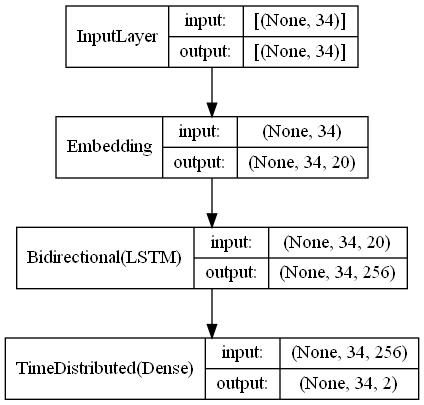

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False)

In [47]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=30, verbose=1)

Epoch 1/30
1400/1400 [==============================] - 287s 201ms/step - loss: 0.0538 - precision: 0.9201 - recall: 0.9201 - accuracy: 0.2199 - val_loss: 0.0387 - val_precision: 0.9364 - val_recall: 0.9364 - val_accuracy: 0.1390
Epoch 2/30
1400/1400 [==============================] - 292s 208ms/step - loss: 0.0374 - precision: 0.9417 - recall: 0.9417 - accuracy: 0.2177 - val_loss: 0.0369 - val_precision: 0.9418 - val_recall: 0.9418 - val_accuracy: 0.1246
Epoch 3/30
1400/1400 [==============================] - 293s 209ms/step - loss: 0.0340 - precision: 0.9487 - recall: 0.9487 - accuracy: 0.1956 - val_loss: 0.0368 - val_precision: 0.9422 - val_recall: 0.9422 - val_accuracy: 0.1881
Epoch 4/30
1400/1400 [==============================] - 287s 205ms/step - loss: 0.0310 - precision: 0.9553 - recall: 0.9553 - accuracy: 0.1991 - val_loss: 0.0379 - val_precision: 0.9415 - val_recall: 0.9415 - val_accuracy: 0.1317
Epoch 5/30
1400/1400 [==============================] - 321s 229ms/step - loss: 

loss: 0.0064 - precision: 0.9924 - recall: 0.9924 - accuracy: 0.4219

val_loss: 0.1306 - val_precision: 0.9364 - val_recall: 0.9364 - val_accuracy: 0.4192

## Вторая модель

In [48]:
# один вход для слов
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)

# другой вход для символов
char_in = Input(shape=(sent_max_len, char_max_len))
emb_char = TimeDistributed(Embedding(input_dim=len(char2id), output_dim=10, input_length=char_max_len))(char_in)
# свертка на символах (CharRNN) применяется к каждому слову отдельно
char_enc = TimeDistributed(Conv1D(filters=12, kernel_size=3))(emb_char)
char_flat = TimeDistributed(Flatten())(char_enc)

# LSTM проходится по всей последовательности, на каждом шаге беря эмбеддинг слова по словарю + символьный эмбеддинг слова 
x = concatenate([emb_word, char_flat])
main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(main_lstm)

model = Model(inputs=[char_in, word_in], outputs=out)


optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()])

In [49]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34, 34)]     0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 34, 34, 10)   700         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 34, 32, 12)   372         time_distributed_2[0][0]         
____________________________________________________________________________________________

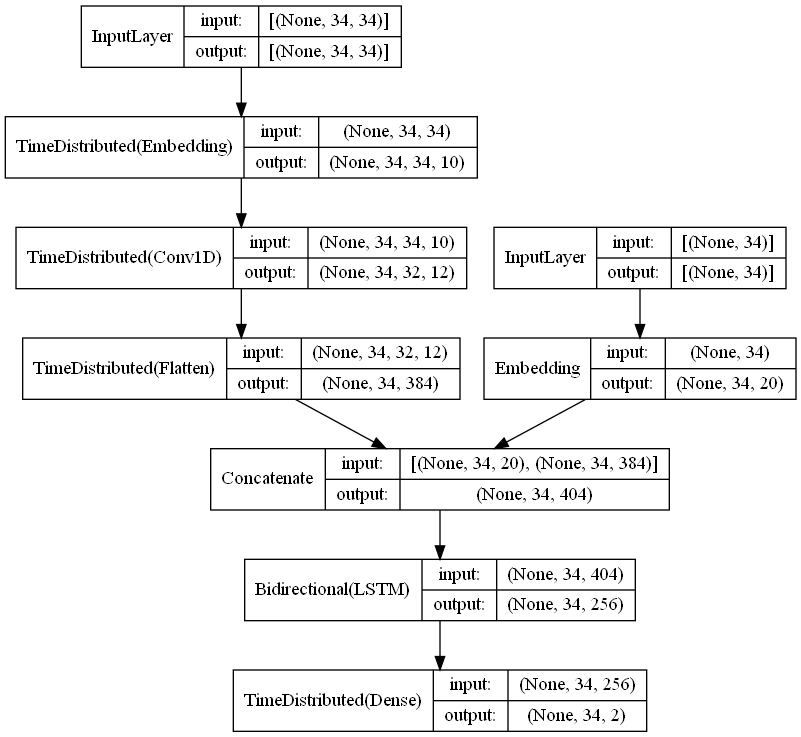

In [50]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.fit([X_char_train, X_train], y_train, validation_data=([X_char_test, X_test], y_test), batch_size=128, epochs=30, verbose=1)

Собственно, в этой модели у меня происходит что-то не то с accuracy и исправить это у меня никак не получилось.